In [1]:
import pandas as pd
import numpy as np
import re
import random 
import pickle
import itertools

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Load GLoVE Embedding

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

In [ ]:
!unzip glove.6B.zip

In [ ]:
!ls -lat

In [ ]:
vocab, embeddings = [], []
with open("glove.6B.50d.txt") as f:
  full_content = f.read().strip().split("\n")
for i in range(len(full_content)):
  ith_word = full_content[i].split()[0]
  ith_emb = [float(val) for val in full_content[i].split()[1:]]
  vocab.append(ith_word)
  embeddings.append(ith_emb)

In [ ]:
vocab_npa = np.array(vocab)
emb_npa = np.array(embeddings)

In [ ]:
vocab_npa = np.insert(vocab_npa, 0, "<pad>")
vocab_npa = np.insert(vocab_npa, 1, "<unk>")

pad_emb_npa = np.zeros((1,emb_npa.shape[1]))
unk_emb_npa = np.mean(emb_npa, axis = 0, keepdims = True)

emb_npa = np.vstack((pad_emb_npa, unk_emb_npa, emb_npa))

In [ ]:
emb_layer = nn.Embedding.from_pretrained(torch.from_numpy(emb_npa).float())
print(emb_layer.weight.shape)

In [ ]:
len(vocab_npa)

# Data Preparation For CharLSTM

In [31]:
with open("../input/movie-plot/plots_text.pickle", "rb") as f:
  data = pickle.load(f)

In [32]:
data = [re.sub("[^a-z',.\d ]", "", text) for text in data]

In [33]:
letters = ['a','b','c','d','e','f','g','h','i','j','k','l','m',
               'n','o','p','q','r','s','t','u','v','w','x','y','z',' ']
char_data = []
for text in data:
  text_char = [char for char in text if char.lower() in letters]
  char_data.append(text_char)

In [34]:
def create_seq(char_array, seq_len):
  sequence = []
  if len(char_array) > seq_len:
    for i in range(seq_len, len(char_array)):
      sequence.append(char_array[i-seq_len:i+1])
  else:
    sequence.append(char_array)

  return sequence

In [35]:
seqs = [create_seq(arr, 50) for arr in char_data]

In [36]:
print(len(seqs))
print(sum([len(arr) for arr in seqs]))

500
851656


In [37]:
seqs = list(itertools.chain(*seqs))

In [38]:
x = []
y = []
for seq in seqs:
  x.append(seq[:-1])
  y.append(seq[1:])

In [39]:
char2idx ={char: idx for idx, char in enumerate(letters)}
idx2char ={idx: char for idx, char in enumerate(letters)}
vocab_size = len(char2idx)

In [40]:
def get_int_seq(seq):
  return [char2idx[i] for i in seq]

In [41]:
x_int = [get_int_seq(seq) for seq in x]
y_int = [get_int_seq(seq) for seq in y]

# Data Preparation For WordLSTM

In [ ]:
with open("/content/plots_text.pickle", "rb") as f:
  data = pickle.load(f)

In [ ]:
data = [re.sub("[^a-z',.\d ]", "", text) for text in data]

In [ ]:
data = [re.sub("[,]"," ,", text) for text in data]

In [ ]:
data = [re.sub("[.]"," .", text) for text in data]

In [ ]:
def create_seq(text, seq_len):
  sequence = []

  if len(text.split()) > seq_len:
    for i in range(seq_len, len(text.split())):
      seq = text.split()[i-seq_len:i+1]
      sequence.append(" ".join(seq))
  else:
    sequence.append(text)

  return sequence

In [ ]:
seqs = [create_seq(text, 5) for text in data]

In [ ]:
seqs = list(itertools.chain(*seqs))

In [ ]:
len(seqs)

In [ ]:
x = []
y = []
for s in seqs:
  x.append(" ".join(s.split()[:-1]))
  y.append(" ".join(s.split()[1:]))

In [ ]:
single_text = " ".join(data)
unique_token_list = list(set(single_text.split()))

token2idx = {token:idx for idx, token in enumerate(unique_token_list)}
idx2token = {idx:token for idx, token in enumerate(unique_token_list)}

In [ ]:
vocab_size = len(token2idx)
vocab_size

In [ ]:
def get_int_seq(seq):
  return [token2idx[w] for w in seq.split()]

In [ ]:
x_int = [get_int_seq(s) for s in x]
y_int = [get_int_seq(s) for s in y]

In [43]:
class MyDataset(Dataset):
  def __init__(self, xs, ys):
    self.x = torch.tensor(xs)
    self.y = torch.tensor(ys)

  def __len__(self):
    return len(self.x)

  def __getitem__(self, idx):
    sample = self.x[idx]
    label = self.y[idx]

    return sample, label

In [44]:
dataset = MyDataset(x_int, y_int)

In [45]:
len(x_int)%32

8

In [46]:
data_loader = DataLoader(dataset, batch_size = 32, shuffle = True, drop_last = True)

In [47]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model Training

In [48]:
class WordLSTM(nn.Module):
  def __init__(self, n_hidden = 256, n_layers = 2, drop_prob = 0):
    super().__init__()

    self.n_hidden = n_hidden
    self.n_layers = n_layers
    self.drop_prob = drop_prob

    self.emb_layer = nn.Embedding(vocab_size, 100)

    self.lstm = nn.LSTM(100, n_hidden, n_layers, dropout=drop_prob, batch_first = True)
    self.dropout = nn.Dropout(0.5)
    self.fc = nn.Linear(n_hidden, vocab_size)

  def forward(self, x, h):
    embedded = self.emb_layer(x)

    out, hn = self.lstm(embedded, h)

    out = self.dropout(out)
    out = out.reshape(-1, self.n_hidden)
    out = self.fc(out)

    return out, hn
  
  def init_hidden(self, batch_size):
    h0 = torch.zeros(self.n_layers, batch_size, self.n_hidden).to(device)
    c0 = torch.zeros(self.n_layers, batch_size, self.n_hidden).to(device)

    return (h0,c0)

In [49]:
device

device(type='cuda')

In [50]:
!nvidia-smi

Sun Sep  4 21:39:51 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    32W / 250W |    853MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [51]:
model = WordLSTM().to(device)

In [52]:
model

WordLSTM(
  (emb_layer): Embedding(27, 100)
  (lstm): LSTM(100, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=27, bias=True)
)

In [53]:
opt = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()
scheduler = ReduceLROnPlateau(opt, patience= 3)
total_steps = len(data_loader)

tr_loss = []
model.train()
for epoch in range(30):
  epoch_loss = 0
  for i, (words,labels) in enumerate(data_loader):
    words = words.to(device)
    labels = labels.view(-1).to(device)
    
    h = model.init_hidden(32)
    outputs, hn = model(words, h)
    loss = criterion(outputs, labels)
    
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    opt.step()
    opt.zero_grad()
    
    epoch_loss += loss
    if (i+1)%1000 == 0:
      d = opt.param_groups[0]["lr"]
      print(f"Epoch [{epoch+1}/{30}], Step [{i+1}/{total_steps}], Loss {loss.item():.4f}, lr {d}")
  tr_loss.append(epoch_loss.item())
  scheduler.step(epoch_loss)

Epoch [1/30], Step [1000/26614], Loss 1.6268, lr 0.001
Epoch [1/30], Step [2000/26614], Loss 1.6101, lr 0.001
Epoch [1/30], Step [3000/26614], Loss 1.3763, lr 0.001
Epoch [1/30], Step [4000/26614], Loss 1.3193, lr 0.001
Epoch [1/30], Step [5000/26614], Loss 1.3792, lr 0.001
Epoch [1/30], Step [6000/26614], Loss 1.3756, lr 0.001
Epoch [1/30], Step [7000/26614], Loss 1.3518, lr 0.001
Epoch [1/30], Step [8000/26614], Loss 1.3117, lr 0.001
Epoch [1/30], Step [9000/26614], Loss 1.2042, lr 0.001
Epoch [1/30], Step [10000/26614], Loss 1.2422, lr 0.001
Epoch [1/30], Step [11000/26614], Loss 1.2130, lr 0.001
Epoch [1/30], Step [12000/26614], Loss 1.2489, lr 0.001
Epoch [1/30], Step [13000/26614], Loss 1.2726, lr 0.001
Epoch [1/30], Step [14000/26614], Loss 1.2826, lr 0.001
Epoch [1/30], Step [15000/26614], Loss 1.2453, lr 0.001
Epoch [1/30], Step [16000/26614], Loss 1.2680, lr 0.001
Epoch [1/30], Step [17000/26614], Loss 1.2019, lr 0.001
Epoch [1/30], Step [18000/26614], Loss 1.2230, lr 0.001
E

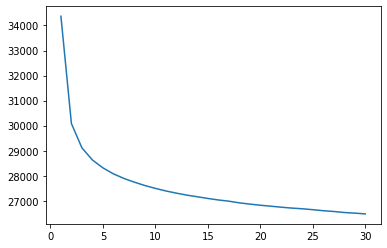

In [54]:
import matplotlib.pyplot as plt
L = [p for p in tr_loss]
plt.plot(np.arange(1,len(L)+1),L)

In [ ]:
torch.save(model.state_dict(),"word_lm")

# Text Generation

In [26]:
def predict(model, token, h):
  x = torch.tensor([[char2idx[token]]]).to(device)
 
  with torch.no_grad():
    out, h = model(x, h)
  
  p = F.softmax(out, dim =1)
  p = p.cpu()
  p = p.numpy()
  p = p.reshape(p.shape[1])

  top_3_idx = p.argsort()[-3:]
  sample_token_idx = top_3_idx[random.sample([0,1,2],1)[0]]

  return idx2char[sample_token_idx], h

In [27]:
def generate_text(model, size, context):
#   token_list = context.split()
  token_list = []
  for char in context:
    token_list.append(char)
  model.eval()
  h = model.init_hidden(1)

  for t in context:
    token, h = predict(model, t, h)
  token_list.append(token)

  for i in range(size-1):
    token, h = predict(model, token_list[-1], h)
    token_list.append(token)
  
  return "".join(token_list)
  

In [55]:
generate_text(model, 100, "as soon as")

'as soon as hasast solagion it isnorm  wooss issus donaldre petersirs antory to thank agroves talkingsmishsay a'

In [56]:
generate_text(model, 100, "they")

'they shalke groun al band himsilicsnifuer an orpania he inniciscstacritess thanks tom  who wild humal ba'

# Evaluation

In [ ]:
# last_epoch_losses = tr_loss[-5334:]
last_epoch_losses = tr_loss[-1]

In [ ]:
total_loss = last_epoch_losses
print(f"Perplexity : {np.exp(total_loss/5334)}")

# Appendix

In [ ]:
con = get_int_seq("it is")
input_data = torch.tensor([con])

In [ ]:
model.eval()
h = model.init_hidden(1)
with torch.no_grad():
  out, h = model(input_data.to(device), h)

In [ ]:
h[0][1:,:,:].shape

In [ ]:
"it".split()

In [ ]:
for i, (words, labels) in enumerate(data_loader):
  w = words
  l=labels
  break

In [ ]:
w.size(), l.size()

In [ ]:
emb_layer = nn.Embedding(vocab_size, 200)
lstm = nn.LSTM(200, 256, 2, dropout=0.3, batch_first = True)
dropout = nn.Dropout(0.3)
fc = nn.Linear(256, vocab_size)

In [ ]:
embedded = emb_layer(w)

In [ ]:
embedded.size()

In [ ]:
h0 = torch.zeros(2, 32, 256)
c0 = torch.zeros(2, 32, 256)
out, hn = lstm(embedded,(h0,c0))

In [ ]:
out.size()

In [ ]:
out = dropout(out)

In [ ]:
out.size()

In [ ]:
out = out.reshape(-1,256)

In [ ]:
out.size()

In [ ]:
out = fc(out)

In [ ]:
out.size()

In [ ]:
out = model(w.to(device))

In [ ]:
out.size()

In [ ]:
l.view(-1).size()

In [ ]:
len(x_int)//32, len(data_loader)

In [ ]:
!nvidia-smi